## **Notebook 07: Classification examples**
### CBE 512. Machine Learning in Chemical Science and Engineering.

&#169; Princeton University

# **Practice with common Classifier algorithms**
In this notebook, we will explore the `scikit-learn` implementations of support vector machines (a class ML technique) and random forest models. These algorithms are most often applied for classification problems, although there are ways to pivot towards regression. Let's see how they work!

In [ ]:
# modules needed for this notebook
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

## **Support Vector Machines**

Support vector machines are an "older" technique, developed in the 90's based on statistical learning theory. They are capable of both performing linear classification, in which the classification of a sample is based on some linear combination of its characteristics, as well as non-linear classification. In terms of how an SVM functions, you can think of the task as trying to find a hyperplane in the feature space that maximally partitions the data; the objective is to find the splitting that maximizes distance of the classes to this high-dimensional surface.

Run the cells below to explore how the complexity of the hyperplane and classification task impacts results. For simplicity, we will just be using a packaged `iris` dataset from `sklearn`, which relates to the taxonomy of flowers. I guess that is kind of science/engineering...

### 1. Simple Linear SVC and Decision Boundary

Study and run the cell below and examine what happens when using a linear decision boundary.

You may add additional lines to ascertain how many samples are in your dataset/training/test split.

***Note:*** Notice how we are using the standard scaler. Very importantly, when we fit the transform, we are only doing so over our *training* data. It is a subtle problem, but fitting over the whole dataset is bad practice that is prone to "data leakage" and bias.

In [ ]:
# load the iris dataset
iris = datasets.load_iris()
X = iris.data[:100, :2] # take only the first two features
# sepal length and width
y = iris.target[:100]

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# create and train a linear SVM model
clf = SVC(kernel="linear", C=1) # vary C, see impact
clf.fit(X_train, y_train)

# prediction on the test set
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Accuracy: {acc*100:0.2f}%")

Accuracy: 100.00%


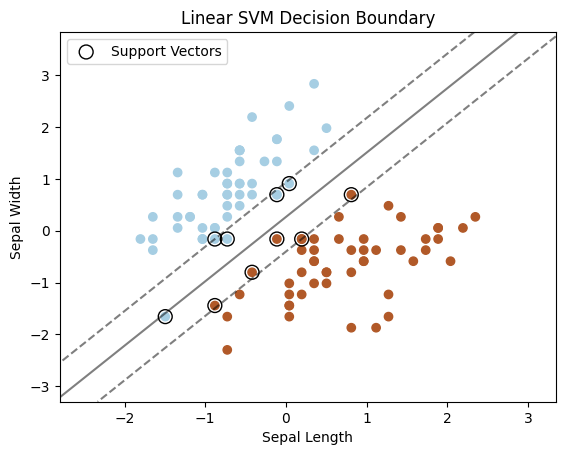

In [ ]:
# plot the decision boundary
fig, ax = plt.subplots()

X_std = scaler.transform(X)
ax.scatter(X_std[:, 0], X_std[:, 1], c=y, cmap=plt.cm.Paired)

# create grid to evaluate model
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

xy = np.c_[xx.ravel(), yy.ravel()]
Z = clf.decision_function(xy).reshape(xx.shape)

# plot decision boundary and margins
ax.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1],
           alpha=0.5, linestyles=["--", "-", "--"])

# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
           s=100, facecolors="none", edgecolors="k", label="Support Vectors")

ax.legend(loc="upper left")
ax.set_xlabel("Sepal Length")
ax.set_ylabel("Sepal Width")
ax.set_title("Linear SVM Decision Boundary")
plt.show();

### 2. SVC with Non-linear Kernels

The linear decision boundary does a pretty good job already. If we elect to use a non-linear boundary, we then have additional decisions to make. These decisions manifest in the selection of a kernel, which supplies a transformation on our feature space. We will explore several different kernels and examine their differences.

Furthermore, using the non-linear separation approach implies that hard-margin will fail. Therefore, our loss function now includes so called slack variables, and this inclusion necessitates the existence of a hyperparameter $C$ that will impact how important we consider this to be. We will show how $C$ affects the results.

In [ ]:
# load the iris dataset
iris = datasets.load_iris()
X = iris.data[:100, :2] # take only the first two features
# sepal length and width
y = iris.target[:100]

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_std = scaler.transform(X)

In [ ]:
# define a function to plot svc decision boundary
def plot_svc_boundary(X_train, y_train, X_test, y_test, kernel, C=1, degree=3):
    clf = SVC(kernel=kernel, C=C, degree=degree)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)

    fig, ax = plt.subplots()
    ax.scatter(X_std[:, 0], X_std[:, 1], c=y, cmap=plt.cm.Paired)

    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                        np.arange(y_min, y_max, 0.01))

    xy = np.c_[xx.ravel(), yy.ravel()]
    Z = clf.decision_function(xy).reshape(xx.shape)

    ax.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1],
            alpha=0.5, linestyles=["--", "-", "--"])

    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=100, facecolors="none", edgecolors="k", label="Support Vectors")

    ax.legend(loc="upper left")
    ax.set_xlabel("Sepal Length")
    ax.set_ylabel("Sepal Width")
    ax.set_title(f"Kernel: {kernel} C: {C} Accuracy: {acc*100:0.2f}%")
    plt.show();

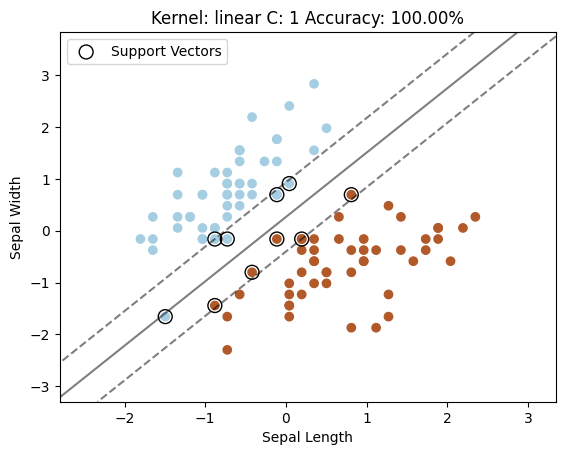

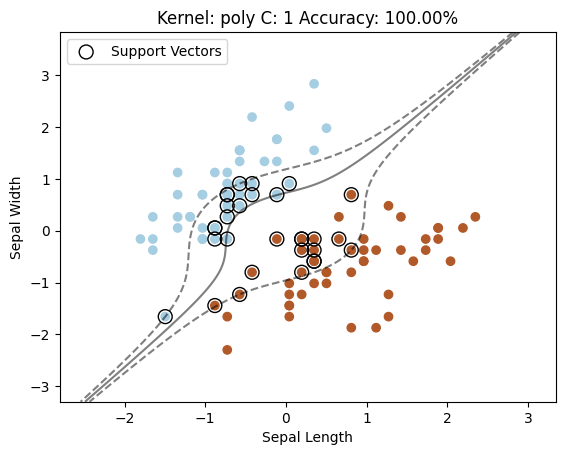

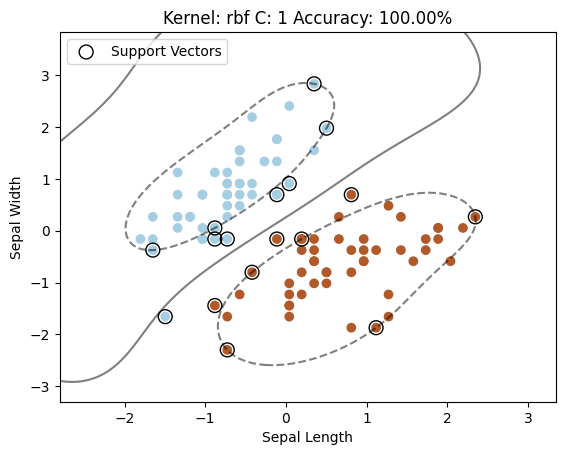

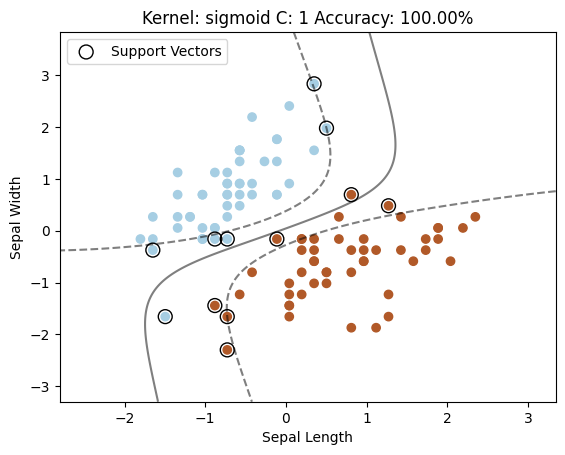

In [ ]:
# plot svc with different kernels
kernels = ["linear", "poly", "rbf", "sigmoid"]

for kernel in kernels:
    plot_svc_boundary(X_train, y_train, X_test, y_test, kernel=kernel, C=1)

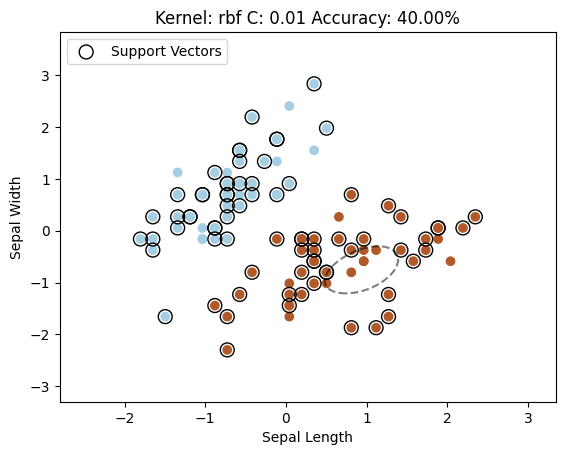

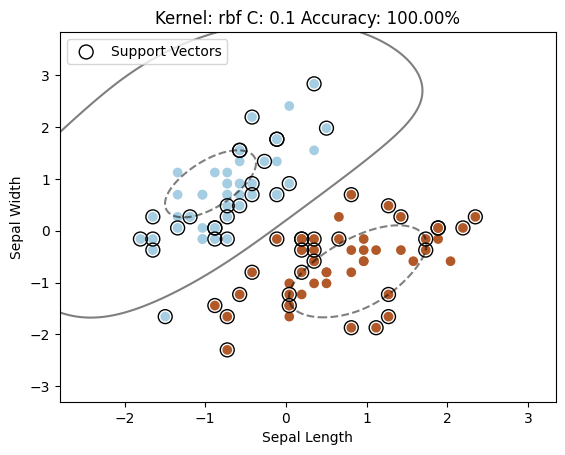

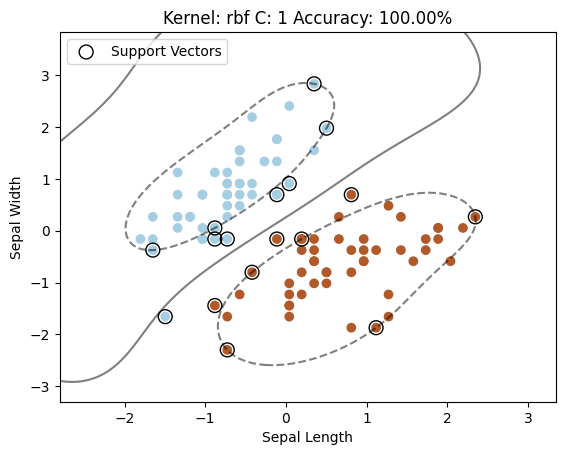

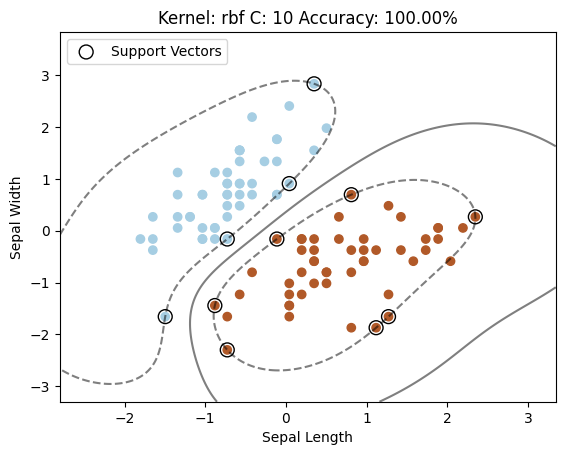

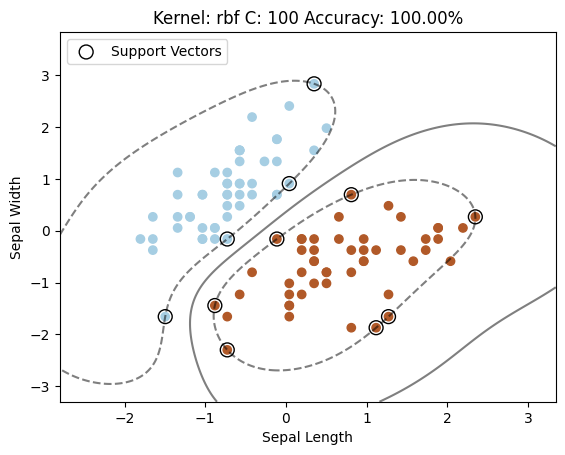

In [ ]:
# plot svc with different C's
Cs = [0.01, 0.1, 1, 10, 100]

for C in Cs:
    plot_svc_boundary(X_train, y_train, X_test, y_test, kernel="rbf", C=C)

### 3. SVC Multi-class Classification

Extension to multi-class classifcation is straightforward and basically amounts to performing mutliple binary classifications in different modes and making predictions from these. We need to consider the mode of classification: one vs. one or one vs. rest. We will see how differently they perform. Do you have any guesses?  

In [ ]:
# load the iris dataset
iris = datasets.load_iris()
X = iris.data[:, :2] # take only the first two features
# sepal length and width
y = iris.target

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_std = scaler.transform(X)

In [ ]:
# define a function to plot decision boundaries
def plot_multi_class_svc_boundary(X_train, y_train, X_test, y_test, model, title):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)

    fig, ax = plt.subplots()
    ax.scatter(X_std[:, 0], X_std[:, 1], c=y, cmap=plt.cm.Paired)

    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                        np.arange(y_min, y_max, 0.02))

    xy = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(xy).reshape(xx.shape)

    ax.contour(xx, yy, Z, colors='k')

    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=100, facecolors="none", edgecolors="k", label="Support Vectors")

    ax.legend(loc="upper left")
    ax.set_xlabel("Sepal Length")
    ax.set_ylabel("Sepal Width")
    ax.set_title(f"{title} Accuracy: {acc*100:0.2f}%")
    plt.show();


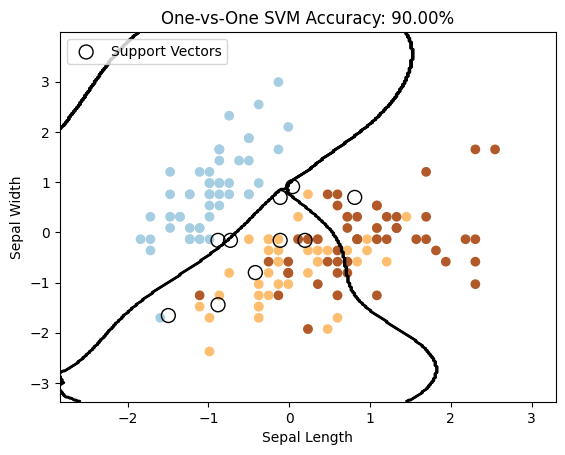

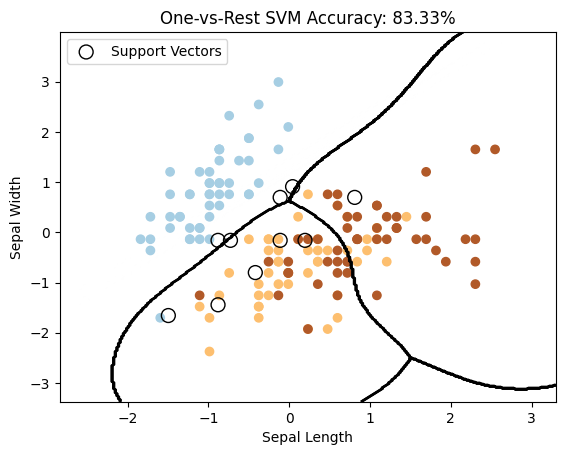

In [ ]:
# one-vs-one
ovo_clf = OneVsOneClassifier(SVC(kernel="rbf", C=1, random_state=42))
plot_multi_class_svc_boundary(X_train, y_train, X_test, y_test,
                              ovo_clf, "One-vs-One SVM")

# one-vs-rest
ovr_clf = OneVsRestClassifier(SVC(kernel="rbf", C=1, random_state=42))
plot_multi_class_svc_boundary(X_train, y_train, X_test, y_test,
                              ovr_clf, "One-vs-Rest SVM")

### 4. SVC Hyperparameter Tuning

To find the best set of hyperparameters for our problem, we often engage in so-called hyperparameter optimization or tuning. A common way to approach this (for tractable model space and dataset size) is to simply perform a grid-search and evaluate all possible models on the grid. The cells below illustrate this with the aid of some helpful functions that automate the implementation (which would not be hard to do on your own!).   

In [ ]:
iris = datasets.load_iris()
X = iris.data[:, :2]
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# define the model
model = SVC()

# define the hyperparameters to tune
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

# set up GridSearchCV with 5-fold cross-validation
# if you have a very large search space, you can use RandomizedSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5,
                           scoring='accuracy', return_train_score=True)

# fit the model
grid_search.fit(X_train, y_train)

# get the best hyperparameters
best_params = grid_search.best_params_

# get the validation accuracies for all combinations of hyperparameters
cv_results = pd.DataFrame(grid_search.cv_results_)

# display the validation accuracies
print("Validation Accuracies for Hyperparameter Combinations:")
print(cv_results[['param_C', 'param_kernel', 'mean_test_score']]) # this is validation score

# train the model with the best hyperparameters on the entire training set and evaluate on the test set
best_model = SVC(**best_params)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

# display the test accuracy for the best hyperparameters
print(f"\nBest Hyperparameters: {best_params}")
print(f"Test Accuracy with Best Hyperparameters: {test_accuracy}")

Validation Accuracies for Hyperparameter Combinations:
   param_C param_kernel  mean_test_score
0      0.1       linear         0.775000
1      0.1          rbf         0.716667
2      0.1         poly         0.650000
3      0.1      sigmoid         0.783333
4        1       linear         0.766667
5        1          rbf         0.766667
6        1         poly         0.675000
7        1      sigmoid         0.783333
8       10       linear         0.775000
9       10          rbf         0.741667
10      10         poly         0.716667
11      10      sigmoid         0.691667
12     100       linear         0.775000
13     100          rbf         0.725000
14     100         poly         0.725000
15     100      sigmoid         0.675000

Best Hyperparameters: {'C': 0.1, 'kernel': 'sigmoid'}
Test Accuracy with Best Hyperparameters: 0.9333333333333333


## **Decision Trees**
Machine learning with decision trees is another very popular approach. You are already likely familiar with the concept of decision trees/flow charts for navigating some process and taking actions according to specific outcomes. Decision trees are functionally very similar. One advantage of decision trees is that they are relatively transparent, such that the results are discernible by human inspection. In a decision tree, the leaves provide labels while the branches are combinations of features that lead such labels.

The cells below will explore the implementation of decision trees for classification.

### 1. Gini Impurity

The Gini impurity is a measure that determines how information flows/is split at a given node on the tree. This is functionally related to the likelihood of random data being misclassified by chance according to the population of possible labels. When certain features possess low impurity, they are good at correctly splitting the data. High impurities (-->0.5) suggest that the information content is low on that feature.

In [ ]:
def gini_impurity(y):
    unique_labels, label_counts = np.unique(y, return_counts=True)
    probabilities = label_counts / len(y)
    gini = 1 - np.sum(probabilities ** 2)
    return gini

def weighted_gini_impurity(y_left, y_right):
    left_size = len(y_left)
    right_size = len(y_right)
    total_size = left_size + right_size
    weighted_gini = (left_size / total_size) * gini_impurity(y_left) + (right_size / total_size) * gini_impurity(y_right)
    return weighted_gini

y_left = np.array([1, 0, 1, 1, 1, 0])
y_right = np.array([0, 0, 0, 1])

print(f"Gini impurity of left node: {gini_impurity(y_left):.4f}")
print(f"Gini impurity of right node: {gini_impurity(y_right):.4f}")
print(f"Weighted Gini impurity of split: {weighted_gini_impurity(y_left, y_right):.4f}")

Gini impurity of left node: 0.4444
Gini impurity of right node: 0.3750
Weighted Gini impurity of split: 0.4167


### 2. Entropy

Entropy is another useful measure of node impurity. In addition the probability of variables, it will also depend on the number of variables. This measure  can be related to information gain by comparisons before/after nodes. You may choose to split by either entropy or gini impurity -- this is a hyperparameter choice.


In [ ]:
def entropy(y):
    unique_labels, label_counts = np.unique(y, return_counts=True)
    probabilities = label_counts / len(y)
    H = - np.sum(probabilities * np.log2(probabilities))
    return H

def weighted_entropy(y_left, y_right):
    left_size = len(y_left)
    right_size = len(y_right)
    total_size = left_size + right_size
    weighted_entropy = (left_size / total_size) * entropy(y_left) + (right_size / total_size) * entropy(y_right)
    return weighted_entropy

y_left = np.array([1, 0, 1, 1, 1, 0])
y_right = np.array([0, 0, 0, 1])

print(f"Entropy of left node: {entropy(y_left):.4f}")
print(f"Entropy of right node: {entropy(y_right):.4f}")
print(f"Weighted entropy of split: {weighted_entropy(y_left, y_right):.4f}")

Entropy of left node: 0.9183
Entropy of right node: 0.8113
Weighted entropy of split: 0.8755


### 3. Simple Decision Tree

So, let's look at the implementation and differences between splitting criterion. As you will also see, we can scrutinize the tree to gain insight into the decision-making process.

In [ ]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# train the decision tree classifier
tree_classifier = DecisionTreeClassifier(criterion="gini", random_state=42)
tree_classifier.fit(X_train, y_train)
y_pred = tree_classifier.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc*100:0.2f}%")

Accuracy: 100.00%


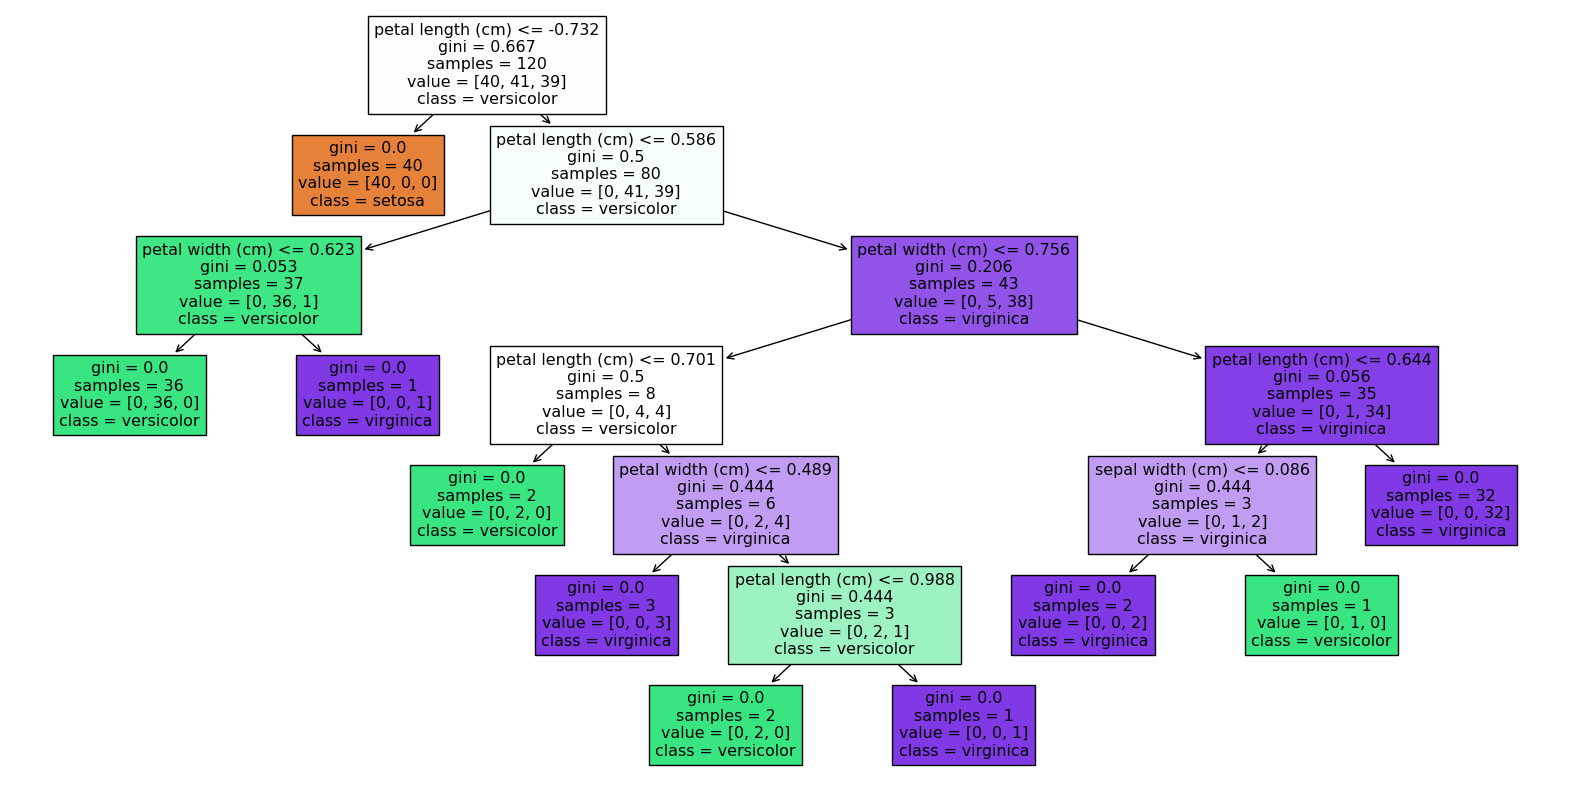

In [ ]:
# visualize the trained decision tree
fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(tree_classifier, filled=True, feature_names=iris.feature_names, class_names=iris.target_names)
plt.show();

In [ ]:
# show the tree rules
tree_rules = export_text(tree_classifier, feature_names=iris.feature_names)
print("Decision Tree Rules:\n", tree_rules)

Decision Tree Rules:
 |--- petal length (cm) <= -0.73
|   |--- class: 0
|--- petal length (cm) >  -0.73
|   |--- petal length (cm) <= 0.59
|   |   |--- petal width (cm) <= 0.62
|   |   |   |--- class: 1
|   |   |--- petal width (cm) >  0.62
|   |   |   |--- class: 2
|   |--- petal length (cm) >  0.59
|   |   |--- petal width (cm) <= 0.76
|   |   |   |--- petal length (cm) <= 0.70
|   |   |   |   |--- class: 1
|   |   |   |--- petal length (cm) >  0.70
|   |   |   |   |--- petal width (cm) <= 0.49
|   |   |   |   |   |--- class: 2
|   |   |   |   |--- petal width (cm) >  0.49
|   |   |   |   |   |--- petal length (cm) <= 0.99
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- petal length (cm) >  0.99
|   |   |   |   |   |   |--- class: 2
|   |   |--- petal width (cm) >  0.76
|   |   |   |--- petal length (cm) <= 0.64
|   |   |   |   |--- sepal width (cm) <= 0.09
|   |   |   |   |   |--- class: 2
|   |   |   |   |--- sepal width (cm) >  0.09
|   |   |   |   |   |--- class: 1

### 4. Decision Tree Hyperparameter Tuning

In [ ]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# define the model
model = DecisionTreeClassifier(random_state=42)

# define the hyperparameters to tune
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


# set up GridSearchCV with 5-fold cross-validation
# if you have a very large search space, you can use RandomizedSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5,
                           scoring='accuracy', return_train_score=True)

# fit the model
grid_search.fit(X_train, y_train)

# get the best hyperparameters
best_params = grid_search.best_params_

# get the validation accuracies for all combinations of hyperparameters
cv_results = pd.DataFrame(grid_search.cv_results_)

# display the validation accuracies
print("Validation Accuracies for Hyperparameter Combinations:")
print(cv_results[['param_criterion', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'mean_test_score']]) # this is validation score

# train the model with the best hyperparameters on the entire training set and evaluate on the test set
best_model = DecisionTreeClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

# display the test accuracy for the best hyperparameters
print(f"\nBest Hyperparameters: {best_params}")
print(f"Test Accuracy with Best Hyperparameters: {test_accuracy}")

Validation Accuracies for Hyperparameter Combinations:
    param_criterion param_max_depth param_min_samples_split  \
0              gini            None                       2   
1              gini            None                       5   
2              gini            None                      10   
3              gini            None                       2   
4              gini            None                       5   
..              ...             ...                     ...   
103         entropy              50                       5   
104         entropy              50                      10   
105         entropy              50                       2   
106         entropy              50                       5   
107         entropy              50                      10   

    param_min_samples_leaf  mean_test_score  
0                        1         0.950000  
1                        1         0.933333  
2                        1         0.941667  
3   

# Random Forest

Random forest algorithms are based on decision trees. The underlying principle here is to use the concept of *ensemble learning*, in effect having many decision trees to help make prediction on labels. This generally mitigates overfitting that may befall a single decision tree and is just overall a superior strategy.

### 1. Simple Random Forest

Below, we will see how to implement random forest. It's so easy! We need to specify the number of estimators now as a hyperparameter.

In [ ]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# train the random forest classifier
forest_clf = RandomForestClassifier(n_estimators=100, criterion="gini", random_state=42)
forest_clf.fit(X_train, y_train)
y_pred = forest_clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc*100:0.2f}%")

Accuracy: 100.00%


### 2. Feature Importance

Because of their relationship to decision trees, it is also straightforward to interrogate the decisions of the forest and ascertain what features were most critical/influential.

In [ ]:
importances = forest_clf.feature_importances_

for feature, importance in zip(iris.feature_names, importances):
    print(f"{feature}: {importance:0.4f}")

sepal length (cm): 0.1081
sepal width (cm): 0.0304
petal length (cm): 0.4400
petal width (cm): 0.4215


### 3. Hyperparameter Tuning

In [ ]:
# define the model
model = RandomForestClassifier(random_state=42)

# define the hyperparameters to tune
param_grid = {
    'n_estimators': [20, 40, 60, 80, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


# set up GridSearchCV with 5-fold cross-validation
# if you have a very large search space, you can use RandomizedSearchCV
grid_search = RandomizedSearchCV(model, param_grid, cv=5, n_iter=100,
                                 scoring='accuracy', return_train_score=True)

# fit the model
grid_search.fit(X_train, y_train)

# get the best hyperparameters
best_params = grid_search.best_params_

# get the validation accuracies for all combinations of hyperparameters
cv_results = pd.DataFrame(grid_search.cv_results_)

# display the validation accuracies
print("Validation Accuracies for Hyperparameter Combinations:")
print(cv_results[['param_n_estimators', 'param_criterion', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'mean_test_score']]) # this is validation score

# train the model with the best hyperparameters on the entire training set and evaluate on the test set
best_model = RandomForestClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

# display the test accuracy for the best hyperparameters
print(f"\nBest Hyperparameters: {best_params}")
print(f"Test Accuracy with Best Hyperparameters: {test_accuracy}")

Validation Accuracies for Hyperparameter Combinations:
   param_n_estimators param_criterion param_max_depth param_min_samples_split  \
0                  40         entropy              30                       5   
1                  40         entropy              30                       5   
2                  20         entropy              10                       5   
3                  20            gini              20                      10   
4                  40         entropy              30                      10   
..                ...             ...             ...                     ...   
95                100         entropy              30                       2   
96                100            gini              20                       5   
97                 20         entropy              30                       2   
98                 20         entropy              30                      10   
99                 80            gini              30 